In [1]:
# Install library for reading JPK File
%pip uninstall pyafmreader --yes
%pip install git+https://github.com/jlopezalo/pyafmreader.git

Found existing installation: pyafmreader x.x.x
Uninstalling pyafmreader-x.x.x:
  Successfully uninstalled pyafmreader-x.x.x
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/jlopezalo/pyafmreader.git to /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-sbdrdrp_
  Running command git clone -q https://github.com/jlopezalo/pyafmreader.git /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-sbdrdrp_
  Cloning https://github.com/TkTech/fasterzip.git to /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-install-vg2r6rdn/fasterzip_35c91726371f4bb19272e5f712cf2fa7
  Running command git clone -q https://github.com/TkTech/fasterzip.git /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-install-vg2r6rdn/fasterzip_35c91726371f4bb19272e5f712cf2fa7
  Using cached numpy-1.21.6-cp38-cp38-macosx_10_9_x86_64.whl (16.9 MB)
  Created wheel for pyafmreader: filename=pyafmreader-x.x.x-py3-none-any.whl si

In [2]:
# Install library for AFM data Rheology Analysis
%pip uninstall pyafmrheo --yes
%pip install git+https://github.com/jlopezalo/pyafmrheo.git

Found existing installation: pyafmrheo 0.0.1
Uninstalling pyafmrheo-0.0.1:
  Successfully uninstalled pyafmrheo-0.0.1
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/jlopezalo/pyafmrheo.git to /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-vq7ktn7q
  Running command git clone -q https://github.com/jlopezalo/pyafmrheo.git /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-vq7ktn7q
  Using cached numpy-1.23.0-cp38-cp38-macosx_10_9_x86_64.whl (18.1 MB)
  Created wheel for pyafmrheo: filename=pyafmrheo-0.0.1-py3-none-any.whl size=26468 sha256=9b56ca21ead884ab3571fe500ea99f98ef8c35320ce82c459f6618322fcd7fa1
  Stored in directory: /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-ephem-wheel-cache-c7f125me/wheels/fb/66/18/3e93b45c845b0d7b83ded1e127a1c127820d070ce5b71dece4
Successfully built pyafmrheo
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling

In [3]:
# Import libraries we will need
import numpy as np
import matplotlib.pyplot as plt

# Get file reader from library
from pyafmreader import loadfile

# Get data analysis tools
from pyafmrheo.utils.force_curves import *
from pyafmrheo.models.hertz import HertzModel
from pyafmrheo.models.ting import TingModel

In [4]:
# Define global variables
file_path = '/Users/javierlopez/Documents/Marseille/05-11-2021/E/map-data-2021.11.05-15.41.45.699.jpk-force-map'
# Shapes available: paraboloid, pyramid
indenter_shape = "pyramid"
# tip_parameter = 500 * 1e-9 # meters
tip_parameter = 35 # degrees
# Poisson ratio
poisson_ratio = 0.5
# If None it will use the deflection sensitivity from the file
deflection_sensitivity = None # m/V
# If None it will use the spring constant from the file
spring_constant = None # N/m
# General plotting params
plt.rcParams["figure.figsize"] = (10,5)

In [5]:
file = loadfile(file_path)

In [6]:
filemetadata = file.filemetadata

In [7]:
closed_loop = filemetadata['z_closed_loop_status']
file_deflection_sensitivity = filemetadata['original_deflection_sensitivity'] #nm/V
file_spring_constant = filemetadata['original_spring_constant'] #N/m
height_channel = filemetadata['height_channel_key']

if not deflection_sensitivity: deflection_sensitivity = file_deflection_sensitivity / 1e9 #m/V
if not spring_constant: spring_constant = file_spring_constant

In [8]:
curve_idx = 0
force_curve = file.getcurve(curve_idx)
extend_segments = force_curve.extend_segments
pause_segments = force_curve.pause_segments
modulation_segments = force_curve.modulation_segments
retract_segments = force_curve.retract_segments
force_curve_segments = force_curve.get_segments()

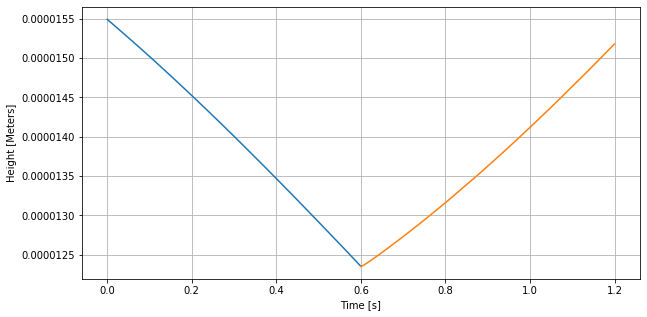

In [9]:
t0 = 0
for seg_id, segment in force_curve_segments:
    height = segment.segment_formated_data[height_channel]
    time = segment.segment_formated_data["time"] + t0
    plt.plot(time, height)
    t0 = time[-1]

plt.xlabel("Time [s]")
plt.ylabel("Height [Meters]")
plt.grid()
plt.show()

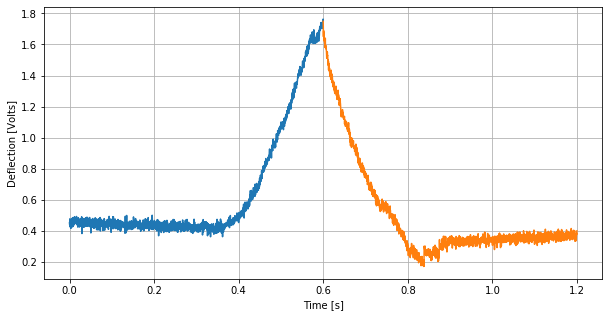

In [10]:
t0 = 0
for seg_id, segment in force_curve_segments:
    deflection = segment.segment_formated_data["vDeflection"]
    time = segment.segment_formated_data["time"] + t0
    plt.plot(time, deflection)
    t0 = time[-1]

plt.xlabel("Time [s]")
plt.ylabel("Deflection [Volts]")
plt.grid()
plt.show()

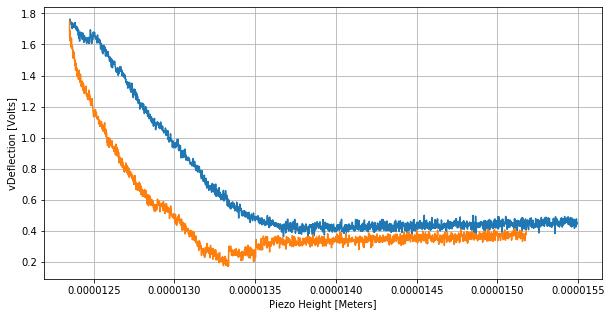

In [11]:
for seg_id, segment in force_curve_segments:
    height = segment.segment_formated_data[height_channel]
    deflection = segment.segment_formated_data["vDeflection"]
    plt.plot(height, deflection)

plt.xlabel("Piezo Height [Meters]")
plt.ylabel("vDeflection [Volts]")
plt.grid()
plt.show()

In [12]:
# Get approach, first extend segment
first_exted_seg_id, first_ext_seg = extend_segments[0]
first_ext_seg.preprocess_segment(deflection_sensitivity, height_channel)

# Get retract, last retract segment
last_ret_seg_id, last_ret_seg = retract_segments[-1]
last_ret_seg.preprocess_segment(deflection_sensitivity, height_channel)

In [13]:
# Shift height
xzero = last_ret_seg.zheight[-1] # Maximum height
first_ext_seg.zheight = xzero - first_ext_seg.zheight
last_ret_seg.zheight = xzero - last_ret_seg.zheight

In [14]:
app_height = first_ext_seg.zheight
app_deflection = first_ext_seg.vdeflection
ret_height = last_ret_seg.zheight
ret_deflection = last_ret_seg.vdeflection

In [28]:
# Find initial PoC, you may get some warnings.
poc = get_poc_RoV_method(app_height, app_deflection, win_size=50)
print(*poc)

1.5863563987854109e-06 1.375145042506078e-09


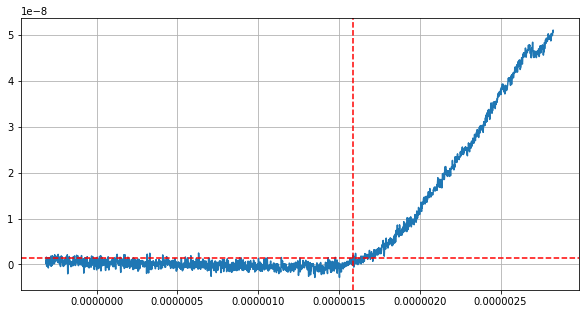

In [29]:
plt.plot(app_height, app_deflection)
plt.axvline(x=poc[0], color='r', linestyle='--')
plt.axhline(y=poc[1], color='r', linestyle='--')
plt.grid()
plt.show()


        # Fit parameters
        Indenter shape: pyramid

        Tip paraneter: 35

        BEC Model: None

        Number of free parameters: 3

        delta0: -8.663430643425886e-07

        E0: 173.95064874725315

        f0: -3.470482045400547e-11

        slope: None

        # Fit metrics
        MAE: -1.538208744072856e-19

        MSE: 1.2324612209815585e-21

        RMSE: 3.5106427060889554e-11

        Rsq: 0.9400092849128113

        Chisq: inf

        RedChisq: inf

        


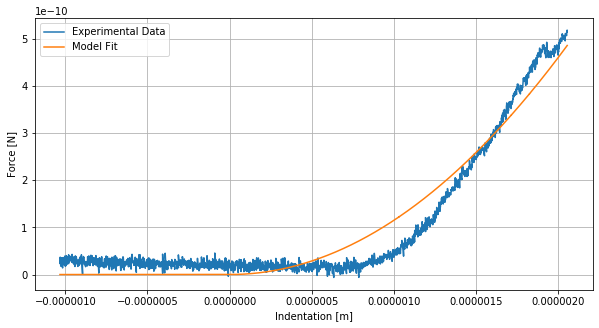

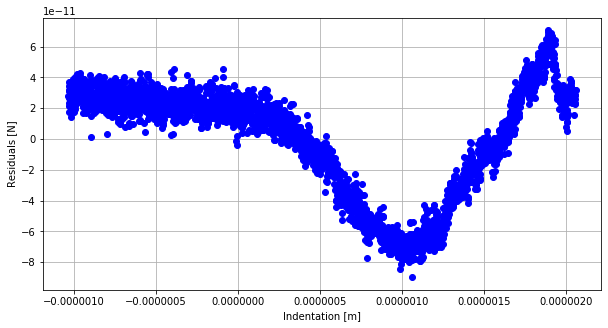

In [30]:
# Hertz fit
first_ext_seg.get_force_vs_indentation(poc, spring_constant)
app_indentation, app_force = first_ext_seg.indentation, first_ext_seg.force

hertzmodel = HertzModel(indenter_shape, tip_parameter)
hertzmodel.fit(app_indentation, app_force)

hertzmodel.fit_report()

hertz_E0 = hertzmodel.E0
hertz_d0 = hertzmodel.delta0
hertz_f0 = hertzmodel.f0

# Plot Hertz Fit results
plt.plot(app_indentation-hertz_d0, app_force-hertz_f0, label="Experimental Data")
plt.plot(app_indentation-hertz_d0, hertzmodel.eval(app_indentation)-hertz_f0, label="Model Fit")
plt.xlabel('Indentation [m]')
plt.ylabel('Force [N]')
plt.legend()
plt.grid()
plt.show()

# Plot residuals
plt.plot(app_indentation-hertz_d0, hertzmodel.get_residuals(app_indentation, app_force), "bo")
plt.xlabel('Indentation [m]')
plt.ylabel('Residuals [N]')
plt.grid()
plt.show()

In [18]:
# Get force vs indentation for all segments
poc[0] += hertz_d0

# Get indentation and force
first_ext_seg.get_force_vs_indentation(poc, spring_constant)
app_indentation, app_force, app_time = first_ext_seg.indentation, first_ext_seg.force, first_ext_seg.time
last_ret_seg.get_force_vs_indentation(poc, spring_constant)
ret_indentation, ret_force, ret_time = last_ret_seg.indentation, last_ret_seg.force, last_ret_seg.time

In [19]:
indentation = np.r_[app_indentation, ret_indentation]
force = np.r_[app_force, ret_force]
t0 = app_time[-1]
time = np.r_[app_time, ret_time + t0]
fit_mask = indentation > (-1 * 1e-6)
ind_fit = indentation[fit_mask] * 1e9
force_fit = force[fit_mask] * 1e9
force_fit = force_fit - force_fit[0]
time_fit = time[fit_mask]
time_fit = time_fit - time_fit[0]
tm = time_fit[np.argmax(force_fit)]
tc = tm/2
idx_tm = np.argmax(force_fit)

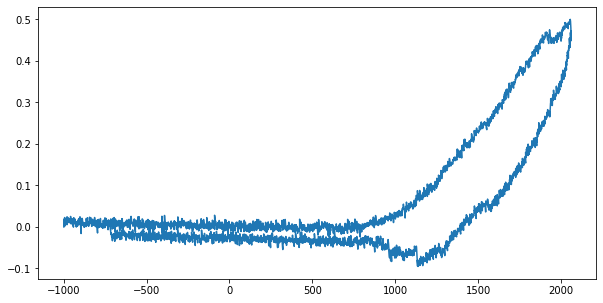

In [20]:
plt.plot(ind_fit, force_fit)
plt.show()

In [21]:
help(TingModel)

Help on class TingModel in module pyafmrheo.models.ting:

class TingModel(builtins.object)
 |  TingModel(ind_geom, tip_param, modelFt) -> None
 |  
 |  Methods defined here:
 |  
 |  SolveAnalytical(self, ttc, trc, t1, model_probe, geom_coeff, v0t, v0r, v0, E0, betaE, t0, F0, vdrag)
 |  
 |  SolveNumerical(self, delta, time_, geom_coeff, geom_exp, v0t, v0r, E0, betaE, F0, vdrag, smooth_w, idx_tm, idxCt, idxCr)
 |  
 |  __init__(self, ind_geom, tip_param, modelFt) -> None
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  eval(self, time, F, delta, t0, idx_tm=None, smooth_w=None)
 |  
 |  fit(self, time, F, delta, t0, idx_tm=None, smooth_w=None)
 |  
 |  fit_report(self)
 |  
 |  get_chisq(self, time, F, delta, t0, idx_tm=None, smooth_w=None)
 |  
 |  get_red_chisq(self, time, F, delta, t0, idx_tm=None, smooth_w=None)
 |  
 |  get_residuals(self, time, F, delta, t0, idx_tm=None, smooth_w=None)
 |  
 |  objective(self, time, E0, tc, betaE, F0, t0, F, delta, m

In [22]:
ting_model_num = TingModel(indenter_shape, tip_parameter, 'numerical')
ting_model_num.fit(time_fit, force_fit, ind_fit, t0=1, idx_tm=idx_tm, smooth_w=5)
ting_model_num.betaE_init = 0.2
ting_model_num.tc_init = tc
ting_model_num.fit_report()
tc_num = ting_model_num.tc
f0_num = ting_model_num.F0

/opt/anaconda3/lib/python3.8/site-packages/pyafmrheo/models/ting.py:240: RuntimeWarning: divide by zero encountered in divide
  return np.sum((self.get_residuals(time, F, delta, t0, idx_tm, smooth_w)**2/F))



        # Fit parameters
        Indenter shape: pyramid

        Tip paraneter: 35

        Model Format: numerical

        Viscous Drag: 0

        Smooth Window: 5

        t0: 1

        Maximum Indentation Time: 2964

        Number of free parameters: 4

        E0: 3.5573397147829095e-08

        tc: -2.0658753964245706e-05

        betaE: 0.2888170269837269

        F0: -0.059872567757548956

        # Fit metrics
        MAE: -0.0005787049073632897

        MSE: 0.0034993108692880307

        RMSE: 0.059154973326746

        Rsq: 0.8105685166845825

        Chisq: inf

        RedChisq: inf

        


In [23]:
ting_model_analit = TingModel(indenter_shape, tip_parameter, 'analytical')
ting_model_analit.fit(time_fit, force_fit, ind_fit, t0=1, idx_tm=idx_tm, smooth_w=5)
ting_model_analit.betaE_init = 0.2
ting_model_analit.tc_init = tc
ting_model_analit.fit_report()
tc_analit = ting_model_analit.tc
f0_analit = ting_model_analit.F0


        # Fit parameters
        Indenter shape: pyramid

        Tip paraneter: 35

        Model Format: analytical

        Viscous Drag: 0

        Smooth Window: 5

        t0: 1

        Maximum Indentation Time: 2964

        Number of free parameters: 4

        E0: 1.896822782443175e-07

        tc: 0.3211999127318429

        betaE: 0.25095215689244654

        F0: -0.017903635780270093

        # Fit metrics
        MAE: -3.4397770912143117e-06

        MSE: 0.0004721312986710622

        RMSE: 0.021728582527883917

        Rsq: 0.974439227146902

        Chisq: inf

        RedChisq: inf

        


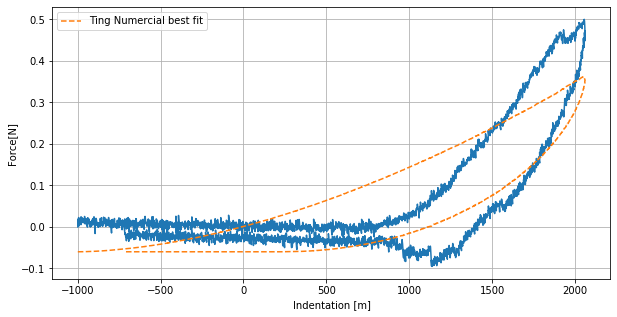

In [24]:
plt.plot(ind_fit, force_fit)
plt.plot(ind_fit, ting_model_num.eval(time_fit, force_fit, ind_fit, t0=t0, idx_tm=idx_tm, smooth_w=5), '--', label='Ting Numercial best fit')
plt.xlabel("Indentation [m]")
plt.ylabel("Force[N]")
plt.legend()
plt.grid()
plt.show()

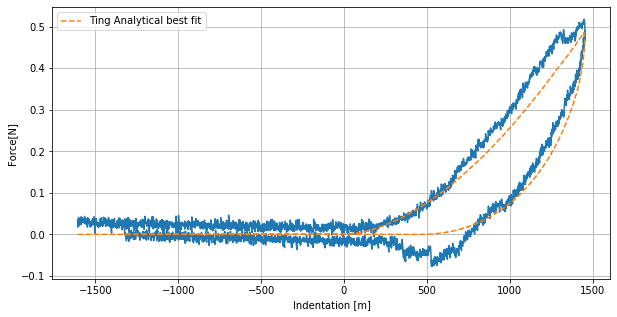

In [25]:
idx_tc = (np.abs(time_fit - tc_analit)).argmin()
delta0 = ind_fit[idx_tc]
plt.plot(ind_fit-delta0, force_fit-f0_analit)
plt.plot(ind_fit-delta0, ting_model_analit.eval(time_fit, force_fit, ind_fit, t0=t0, idx_tm=idx_tm, smooth_w=5)-f0_analit, '--', label='Ting Analytical best fit')
plt.xlabel("Indentation [m]")
plt.ylabel("Force[N]")
plt.legend()
plt.grid()
plt.show()

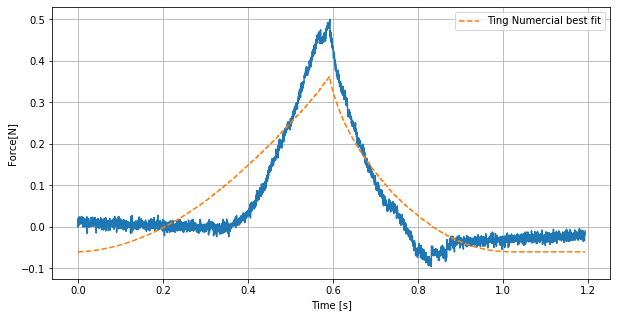

In [26]:
plt.plot(time_fit-tc_num, force_fit)
plt.plot(time_fit-tc_num, ting_model_num.eval(time_fit, force_fit, ind_fit, t0=t0, smooth_w=5), '--', label='Ting Numercial best fit')
plt.xlabel("Time [s]")
plt.ylabel("Force[N]")
plt.legend()
plt.grid()
plt.show()

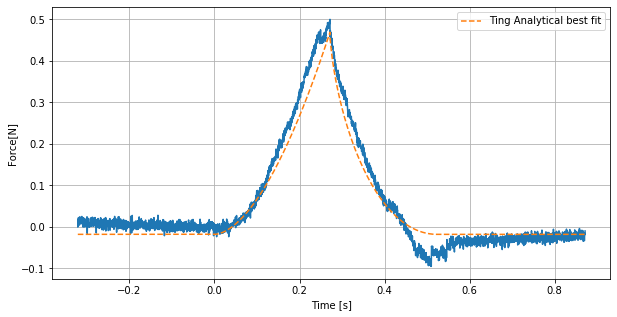

In [27]:
plt.plot(time_fit-tc_analit, force_fit)
plt.plot(time_fit-tc_analit, ting_model_analit.eval(time_fit, force_fit, ind_fit, t0=t0, smooth_w=5), '--', label='Ting Analytical best fit')
plt.xlabel("Time [s]")
plt.ylabel("Force[N]")
plt.legend()
plt.grid()
plt.show()